In [3543]:
# Gravity Drained Tanks in Series
# We'll start with a straightforward model for a pair of gravity drained
#% tanks in series. 
#%
#%    _______
#%           |  q_in (manipulated)
#%           v
#%        -------
#%       |       |  Area = A1
#%       |       |
#%        -------
#%    ----   |
#    q_d  |  |  q1 = C1*sqrt(h1)
#%        v  v
#%        -------
#%       |       |  Area = A2
#%       |       |
#%        -------
#%           |
#%            -----> q2 = C2*sqrt(h2)
#%
# % The model equations are
# %
#%   dh(1)/dt = (qin(t) - C1*sqrt(h(1)))/A1
#%   dh(2)/dt = (qd(t) + C1*sqrt(h(1)) - C2*sqrt(h(2)))/A2
#%
#% q_d is an unmeasured inflow to tank 2. The control objective is to
#% maintain a desired level in tank 2 and thereby a steady outflow q2 by
#% adjusting the manipulable variable q_in.
#%
#% The right hand side of the differential equations are given in the form a
#% function of time (t), a vector of tank levels (h), and functions of time
#% that return values for qin(t) and qd(t)

# import imporant packages
import math 
import numpy
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pylab
from operator import add 
from scipy.interpolate import interp1d
%matplotlib inline


# Model Parameters

A1 = 2.0;
C1 = 1.2;
A2 = 3.0;
C2 = 1.0;
h1store = [0];
h2store = [0];
Hmatrix = np.matrix([h1store,h2store])
qin = []
qd = []
# Model equations

def dHtankone(t,h1,qin,qd):
    dh = (qin - C1*np.real(math.sqrt(h1)))/A1
    return dh
def dHtanktwo(t,h1,h2,qin,qd):
    dhtwo = (qd + C1*np.real(math.sqrt(h1)) - C2*np.real(math.sqrt(h2)))/A2
    return dhtwo
dHtanktwo(10,10,10,10,10);

In [3544]:
qin_nominal = 1.0;
qd_nominal = 0.0;

def qinfunction(t):
    qin = qin_nominal
    return qin
def qdfunction(t):
    qd = qd_nominal
    return qd
def height(M,t):
    h1 = M[0];
    h2 = M[1];
    qin = qinfunction(t);
    qd = qdfunction(t);
    X1 = dHtankone(t,h1,qin,qd)
    X2 = dHtanktwo(t,h1,h2,qin,qd)
    dH = [X1,X2]
    return dH
#start = [0,0,0,1]

#dH = height(start,0)
tf = 150;
h1_initial = 0;
h2_initial = 0;
#h1.append(h1_initial);
#h2.append(h2_initial);
#h1store.append(dH[0]);
#h2store.append(dH[1]);
#Hmatrix = np.matrix([h1store,h2store])

time = numpy.linspace(0.0, tf, 1000)
start = [0,0]


In [3545]:
f = odeint(height, start, time)
print f

[[ 0.          0.        ]
 [ 0.05994069  0.0075329 ]
 [ 0.10883878  0.01928267]
 ..., 
 [ 0.69444444  1.        ]
 [ 0.69444444  1.        ]
 [ 0.69444444  1.        ]]


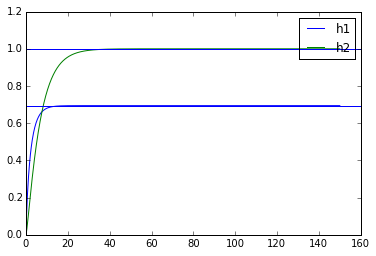

In [3546]:
plt.plot(time,f)
plt.legend(['h1','h2'])
plt.hold(True)
h_ss = f[-1,:]
plt.axhline(y = h_ss[0], xmin = 0, xmax = 1, hold = None)
plt.axhline(y = h_ss[1], xmin = 0, xmax = 1, hold = None)

In [3547]:
h_ss = f[-1,:]

In [3548]:
# Establish a Reference function
def href(t):
    hreff = h_ss[1] + min(.1*t, .5) - .7*(t>=120)
    return hreff
# Redefine Qd
def qdfunction(t):
    qd = .3*((t>= 50) & (t<70));
    return qd
# Turn Time into Discreet Time
dt = 2.0;
tf = 200;
time_discrete = np.linspace(0,200,101)

In [3549]:
h = h_ss
I = 0;
k = 0;
yrefstore = [0]
p1 = [h_ss[1]]
#p2 = [h_ss[0]]
#p3 = [h_ss[1]]
qinf = [1]

while k < len(time_discrete) - 1:
    # Our Measured Value
    y = h[1] - h_ss[1];
    # The PI Controller
    yref = href(time_discrete[k]) - h_ss[1];
    yerr = yref - y;
    P = .6*yerr;
    I = I + .1*dt*yerr;
    u = P + I;
    # Actuator 
    qin_last = qinfunction(time_discrete[k])
    qin_delta = (qin_nominal + u) - qin_last;
    def qinfunction(ts):
        qin = qin_last + (ts > time_discrete[k])*qin_delta;
        return qin
    tiwtp = qinfunction(time_discrete[k+1])
    qinf.append(tiwtp)
    # Process Simulation
    M = [h[0],h[1]]
    timeinter = [time_discrete[k],time_discrete[k+1]]
    Hsim = odeint(height, M, [time_discrete[k], time_discrete[k+1]])
    h = Hsim[-1,:]
    k = k+1
    # Visualization
    p1.append(y+h_ss[1])
    #p2.append(Hsim[-1,0])

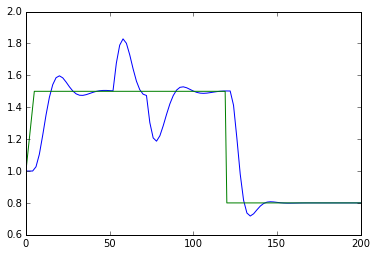

In [3550]:
plt.plot(time_discrete, p1)
hrf = [href(0)]
time = numpy.linspace(0,200,201)
for t in range(1,201):
    hrf.append(href(t))
plt.plot(time, hrf)

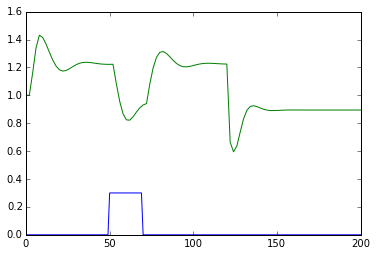

In [3551]:
#addlist = np.ones(len(p2))*.3
#plt.plot(time_discrete, map(add, p2, addlist))


qdf = [qdfunction(0)]
for t in range(1,201):
    qdf.append(qdfunction(t))
    
plt.plot(time, qdf,)

plt.plot(time_discrete,qinf,)


In [3552]:
## Demo 3 Linearization
# For detailed control design we will need a linear model that approximates
# the response of the two-tank system in the neighhborhood of a typical
# operating point. The model will be in the form
#
#   dx/dt = A*x + B*u + Ed
#       y = C*x + D*u + Fd
#
# where state vector x denotes deviations of tank heights from the steady
# state operating point, u denotes deviations in the manipulable input qin,
# and d denotes deviations in the nominal disturbance qd. Here we derive
# analytical expressions for the partial derivatives of f with respect to
# all of these variables, and evaluate at the steady state computed above.

A = np.array([[-C1/(2*A1*math.sqrt(h_ss[0])), 0],[C1/(2*A2*math.sqrt(h_ss[0])), -C2/(2*A2*math.sqrt(h_ss[1]))]])
B = np.array([1/A1, 0])
E = np.array([0, 1/A2])
C = [0, 1]
D = [0]
F = [0]

In [3553]:
# Now compare the response of the nonlinear model and the linear
# approximation for typical inputs. A time grid is set up, then used to for
# a nonlinear simulation starting at the nominal steady state and with some
# time-varying inputs. The simulation is then repeated for the nonlinear
# model after constructing the initial condition and inputs in terms of the
# deviations from the nominal steady state.

# simulation horizon
tf = 80
t = numpy.linspace(0,tf,1601)

# nonlinear simulation
def qinfunction(t):
    qin = qin_nominal + 0.2*(t>=10) - 0.4*(t>=40)
    return qin
h = odeint(height, h_ss, t)

# linear simulation
def ufunction(t):
    return qinfunction(t) - qin_nominal
def dfunction(t):
    return qdfunction(t) - qd_nominal

x_initial =  np.array([0,0])
def linfunction(x,t):
    return np.dot(A,x) + B*ufunction(t) + E*dfunction(t)

In [3554]:
x = odeint(linfunction, x_initial, t)

In [3555]:
#np.dot(A,x_initial) + np.dot(B,ufunction(15)) + np.dot(E, dfunction(15))


(0, 1.4)

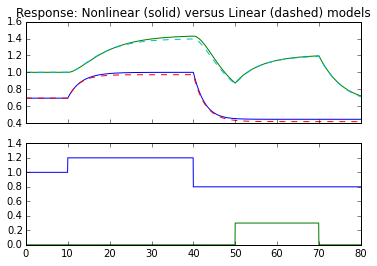

In [3556]:
#%%
#% The simulation results are displayed by converting the linear deviation
# variables back to values corresponding to the actual process variables.
#% This allows for a better comparison of the nonlinear and linear models.

f, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(t,h)
axarr[0].plot(t,x+h_ss,'--')
axarr[0].set_title('Response: Nonlinear (solid) versus Linear (dashed) models')
axarr[1].plot(t,qinfunction(t))
axarr[1].plot(t,qdfunction(t))
plt.ylim([0,1.4])






In [3557]:
#%% Demo 4. Discrete Time Transformation with ZOH
#% Model predictive control is normally implemented in discrete time. We
#% therefore need a discrete time version of the linearized model that we'll
# construct using matrix exponentials. The model is in the form
#%
#%   x(k+1) = Ad*x(k) + Bd*u(k) + Ed*d(k)
#%     y(k) = C*x(k) + D*u(k) + F*d(k)
#%
#% x(k), u(k), d(k), y(k) refer to values of the linear model evaluated at
#% time t(k) where k is the sample numbe, and k=1 is the initial condition.
#% Note that C, D, and F are the same for the discrete-time and
#% continuous-time models.

#import expm function
from scipy.linalg import expm, inv

#sample time
dt=2.0;
A = np.matrix([[-C1/(2*A1*math.sqrt(h_ss[0])), 0],[C1/(2*A2*math.sqrt(h_ss[0])), -C2/(2*A2*math.sqrt(h_ss[1]))]])
B = np.array([[1/A1], [0]])
E = np.array([[0], [1/A2]])

#discrete-time model 
Ad=expm(A*dt);
Bd=(expm(A*dt)-numpy.matrix(numpy.identity(2)))*inv(A)*B;
Ed=(expm(A*dt)-numpy.matrix(numpy.identity(2)))*inv(A)*E;
Ad1=Ad[0]
Ad2=Ad[1]
Ad=np.matrix([Ad1, Ad2])

    

(-0.3, 0.3)

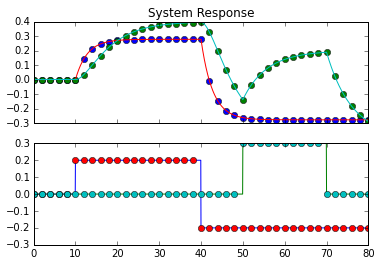

In [3558]:
#%%
#% Next we construct simulations using both the discrete-time and
#% continuous-time models.

xi1 = [0];
xi2 = [0];
x_initial = np.matrix([xi1,xi2])

# discrete time simulation
td = numpy.linspace(0,tf,tf/dt+1);
xd = x_initial;

for k in range (1,len(td-1)):
    xd = np.c_[xd,np.dot(Ad,xd[:,k-1])+np.dot(Bd,ufunction(td[k-1]))+np.dot(Ed,dfunction(td[k-1]))]

# flip matrix to row vector
xd= xd.T

#continues-time model taken from Demo 3

f, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(td,xd,'o')
axarr[0].plot(t,x)

axarr[0].set_title('System Response')
axarr[1].plot(t,ufunction(t))
axarr[1].plot(t,dfunction(t))
axarr[1].plot(td,ufunction(td),'o')
axarr[1].plot(td,dfunction(td),'o')
plt.ylim([-.3,.3])


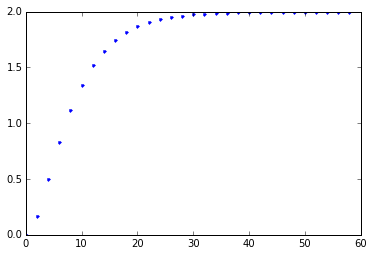

In [3559]:
#%% Demo 5. Step Response Matrix
#% As outlined in Chapter 20 of the (SEMD) textbook, the computations for
#% Model Predictive Control can formulated in terms of the step response
#% matrix. The step response matrix is computed using the step response of
#% the discrete-time linear model, which is computed by finding the values
#% of the output starting at steady state, and where the manipuleable input
#% is a unit step.

#% prediction and control horizons
dt = 2.0;
tprediction = 50;
tcontrol = 8;

tpred = np.linspace(0,tprediction+tcontrol,((tprediction+tcontrol)/dt)+1);

#% unit step input
def ufunction(t):
    upred=1.0;
    return upred

#% compute unit step response
x1=[0]
x2=[0]
x = np.matrix([x1,x2]);

#cant make ystep an empty matrix leads to extra point on graph
ystep=[0];

for k in range(0,len(tpred)):
    ystep = np.c_[ystep,np.dot(C,x)+np.dot(D,ufunction(tpred[k]))]
    x= np.dot(Ad,x) + np.dot(Bd,ufunction(tpred[k]))
    
ystep = ystep.T[range(1,31)]
#weird range ^^ because of extra point from ystep

plt.plot(tpred,ystep,'.')


In [3560]:
## Establish Toeplitz Matrix

from scipy.linalg import toeplitz
# toeplitz function 
steps = int(tcontrol/dt);

ytoe = ystep

ytoe = np.array(ytoe)
ytoe = ytoe.tolist()
zerovector = np.zeros(steps+1)
S = toeplitz(ytoe,zerovector)


(0, 2)

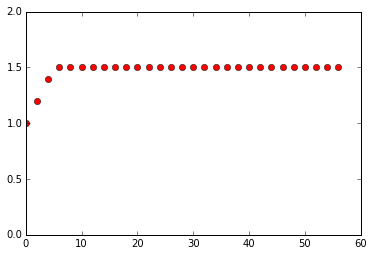

In [3561]:
#%% Demo 6. Computing an Open Loop Control Policy
#% As a first step towards feedback control, let's look at using the step
#% response matrix to compute the control moves necessary to acheive a
# desired change in the level of tank 2. We start with desired reference
#% trajectory for future values of level in tank 2.

#%href = @(t) h_ss(2) + min(0.1*t, 0.5);

for k in range(0,len(tpred)-1):
    plt.plot(tpred[k],href(tpred[k]),'ro')
    plt.hold(True)
plt.ylim(0,2)

#%%
#% A series of control moves du are computed by 'solving' the equation
#%
#%   yref = S*du
#%
#% where
#% 
#%   yref = href = h_ss
#%
#% and u is reconstructed from du by taking a cumulative sum. The quotes
#% around 'solving' are because there are more equations than unknowns, so
#% the best we can do (without further knowledge) is a regression.

In [3562]:
def yreffunction(t):
    yref= href(t) - h_ss[1]
    return yref
yreffunction
yrefsave=np.zeros(len(S))
for k in range(0,len(S)):
    #yref= np.c_[yref,yreffunction(tpred[k])]
    #print yref
    yrefsave[k]= yreffunction(tpred[k])
    #yref = np.vstack((yref,yrefnew))

np.array(yrefsave)
print len(yrefsave)
print len(S)
S = np.reshape(S,(len(S),steps+1))
du= np.linalg.lstsq(S,yrefsave)[0]
#du = S\yref[tpred]
du=du.T
print du

30
30
[ 1.14444852 -0.94682513  0.07216944 -0.11428922  0.09468556]


In [3563]:
## The Following Function Was supplied by Professor Jeff Kantor, University of Notre Dame
def interp0(x, xp, yp):
    """Zeroth order hold interpolation w/ same
    (base)   signature  as numpy.interp."""

    def func(x0):
        if x0 <= xp[0]:
            return yp[0]
        if x0 >= xp[-1]:
            return yp[-1]
        k = 0
        while x0 > xp[k]:
            k += 1
        return yp[k-1]

    return map(func, x)


[  0.   2.   4.   6.   8.  10.  12.  14.  16.  18.  20.  22.  24.  26.  28.
  30.  32.  34.  36.  38.  40.  42.  44.  46.  48.  50.  52.  54.  56.  58.]


(0, 2)

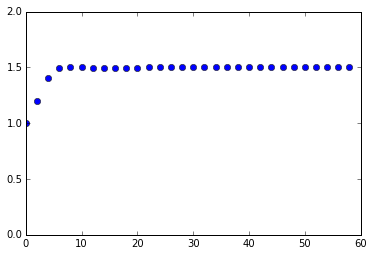

In [3564]:
## Convert Control Moves to a Continuous Control Policy
from scipy import interp
linearrange = np.linspace(0,tcontrol,tcontrol/dt+1)
linearrange = np.array(linearrange)
def ufunction(t):
    return interp0(t,linearrange, np.cumsum(du))
def qinfunction(t):
    X = (qin_nominal*np.ones(len(linearrange))).T + ufunction(linearrange)
    return X
#print ufunction(5)
#np.cumsum(du)
print tpred
R = h_ss[1] + np.dot(S,du)
plt.plot(tpred, R,'bo')
plt.hold(True)
plt.ylim(0,2)
#plt.plot()

In [3565]:
(qin_nominal*np.ones(len(linearrange))).T + ufunction(linearrange)

array([ 2.14444852,  2.14444852,  1.19762339,  1.26979283,  1.25018917])

In [3566]:
ufunction(linearrange)

[1.1444485183486417,
 1.1444485183486417,
 0.19762338865704643,
 0.26979282983183561,
 0.2501891671564605]

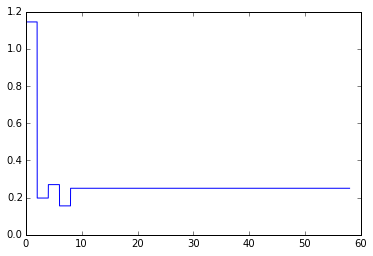

In [3567]:

t = np.linspace(0,tpred[-1],2901)
#plt.plot(t,qinfunction(t),'r')

plt.plot(t,interp0(t,linearrange, np.cumsum(du)))

#  Demo 7. Feedback Implementation of Model Predictive Control
 The open loop implementation has obvious problems in correcting for the
 effects of model error and unmeasured disturbances. The following cell
 demonstrates a feedback implementation in which a vector ypred is used to
 store projections of the future output.  At each time step a new
 measurement is taken. If there is a mismatch, it assumed the mismatch
 will bias all future predictions by the same amount, and therefore added
 to the current prediction. Control moves are then calculated to push the
 revised prediction to the desired reference tranjectory. The control
 moves are limited feasible values before being applied to the process.

In [3568]:
dt = 2
t = np.linspace(0,200,101)
ypred = np.zeros(len(tpred))
h = h_ss
u = 0

def qinfunction(t):
    return qin_nominal
qin_min = 0.0
qin_max = 2.0
du_max = .5
du_min = -.5

def href(t):
    hreff = h_ss[1] + min(.1*t, .5) - .7*(t>=120)
    return hreff

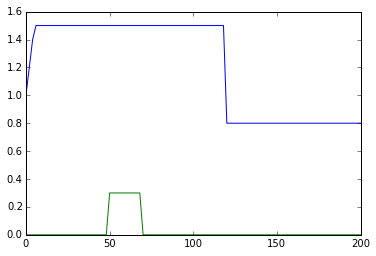

In [3569]:
hrefvector = np.zeros(len(t))
for i in range(0,len(t)):
    hrefvector[i] = href(t[i])

plt.plot(t,hrefvector)
plt.hold(True)
plt.plot(t,qdfunction(t))

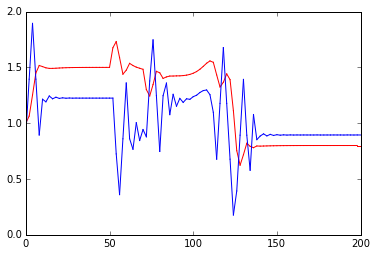

In [3573]:
h = h_ss
for k in range(0,len(t)-1):
    leastsquare = np.zeros(len(tpred))
    y = h[1] - h_ss[1]
    ## Shift Prediction
    ypredsave = (ypred[-1])
    ypredremove = (ypred[0])
    ypred = ypred.tolist()
    ypred.remove(ypredremove)
    ypred.append(ypredsave)
    ydisturbance = np.add(y,-ypred[0])
    ypred = np.add(ypred,ydisturbance) 
    for j in range(0,len(tpred)):
        leastsquare[j] = yreffunction(t[k] + tpred[j]) - ypred[j]
    du = np.linalg.lstsq(S,leastsquare)[0][0]
    du = min(du, qin_max-qinfunction(t[k]))
    du = max(du, qin_min-qinfunction(t[k]))
    du = min(du, du_max)
    du = max(du, du_min)
    ypred = np.add(ypred,S[:,0]*du)
    qin_last = qinfunction(t[k+1])
    def qinfunction(ts):
        A = qin_last + duf*(ts > t[k])
        return A
    duf = du
    timevector = [t[k], t[k+1]]
    f = odeint(height,h,timevector)
    h = f[1,:]
    plt.hold(True)
    plt.plot([t[k], t[k+1]],[f[0,1],f[1,1]], 'r')
    plt.plot([t[k],t[k+1]], [qinfunction(t[k]), qinfunction(t[k+1])], 'b')

In [3600]:
## Demo 8. Feedback Implementation of Model Predictive Control with CVX
# The solution to the equation

#   (yref-ypred) = S*du

# involves possible contraints. For example, there are upper and lower
# bounds on the manipulable inflow, and on changes in the manipulable
# inflow. In the previous implementation these constraints were enforced
# after solving for du, so no accommodation was made by the controller
# itself for the impact of these constraints on control performance.

# This cell demonstrates the significant improvement in closed-loop
# performance that can be acheived by incorporating constraints directly
# into the control calculations using constrained optimization.

from cvxopt import matrix, solvers

# discrete simulation horizon 
dt = 2.0
t = np.linspace(0,200,101)

# Vector to predicted values of y
ypred = np.zeros(len(tpred))

# current tank heights
h = h_ss
u = 0

# Initialize control
def qinfunction(t):
    return qin_nominal

# plotting
hrefvector = np.zeros(len(t))
for i in range(0,len(t)):
    hrefvector[i] = href(t[i])
    
plt.plot(t,hrefvector,'r')
plt.plot(t,qdfunction(t),'r')

for k in range(0,len(t)-1):
    # get current measurment
    y = h[1]-h_ss[1]
    # shift prediction to new time
    ypredsave = (ypred[-1])
    ypredremove = (ypred[0])
    ypred = ypred.tolist()
    ypred.remove(ypredremove)
    ypred.append(ypredsave)
    # compare measurment to prediction
    ydisturbance = np.add(y,-ypred[0])
    # measurment mismatch update
    ypred = np.add(ypred,ydisturbance) 
    
    # Compute control moves needed push ypred to yref
    for j in range(0,len(tpred)):
        leastsquare[j] = yreffunction(t[k] + tpred[j]) - ypred[j]
    
    
    
    du = dv(1)
    
    # control udapte assuming we implement the first control move
    ypred = np.add(ypred,S[:,0]*du)
    
    # Actuator model
    qin_last = qinfunction(t[k+1])
    def qinfunction(ts):
        A = qin_last + duf*(ts > t[k])
        return A
    duf = du
    
    # process simulation
    timevector = [t[k], t[k+1]]
    f = odeint(height,h,timevector)
    h = f[1,:]
    
    # Visualization
    plt.plot([t[k], t[k+1]], [f[0,1],f[1,1]], 'b')
    plt.plot([t[k], t[k+1]], [f[0,0], f[1,0]] ,'r' )
    plt.plot([t[k], t[k+1]], [qinfunction(t[k]),qinfunction(t[k+1])], 'g')

SyntaxError: invalid syntax (<ipython-input-3600-4c8134e42a63>, line 58)